In [25]:
# Import dependencies
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Load file into dataframe
file_path = "../NFL.csv"
nfl_df = pd.read_csv(file_path)
nfl_df.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


In [4]:
# Drop columns that we won't use
bad_columns = ['Year', 'Player', 'Age', 'School', 'Drafted..tm.rnd.yr.', 'Player_Type', 'Position']
nfl_df = nfl_df.drop(bad_columns, axis=1)
nfl_df.head()

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position_Type,Drafted
0,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,backs_receivers,Yes
1,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,defensive_lineman,Yes
2,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,41.005821,offensive_lineman,Yes
3,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,defensive_back,Yes
4,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,line_backer,Yes


In [5]:
nfl_df_dropped = nfl_df.dropna()
nfl_df_dropped['Position_Type'].value_counts()

backs_receivers      565
offensive_lineman    345
defensive_back       330
defensive_lineman    290
line_backer          199
other_special          2
Name: Position_Type, dtype: int64

In [6]:
def rf_model(df, position_type):
    # Create dataframe for features
    X = df.drop(["Drafted", "Position_Type"], axis=1)
    
    # Create target variable
    y = df.Drafted.values
    
    # Seperate into training and testing sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=5)
    
    # Creating a StandardScaler instance.
    scaler = StandardScaler()
    # Fitting the Standard Scaler with the training data.
    X_scaler = scaler.fit(X_train)
    # Scaling the data.
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create and fit the model
    model = BalancedRandomForestClassifier(n_estimators = 128, random_state = 10)
    model.fit(X_train_scaled, y_train)
    
    # Use the model to predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculated the balanced accuracy score
    accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print the imbalanced classification report
    class_report = classification_report_imbalanced(y_test, y_pred)
    
    # List the features sorted in descending order by feature importance
    features = sorted(zip(model.feature_importances_, X.columns), reverse=True)
    
    #Put all useful results into a dictionary
    results = {'Position_Type': position_type,'Accuracy': accuracy, 'cm': cm, 'class_report': class_report, 'features': features}
    
    # Return that dictionary
    return results

In [7]:
# Create an empty list to hold results
results = []

# Go through each position type
for position_type in nfl_df_dropped['Position_Type'].unique():
    if position_type == 'other_special':
        pass
    
    else:
        # Make a dataframe of players just in that position
        df = nfl_df_dropped.loc[nfl_df_dropped['Position_Type']==position_type]
        # Make a random forest model for this position and append the results to the results list
        results.append(rf_model(df, position_type))

In [8]:
for result in results:
    print(result['Position_Type'], result['Accuracy'])

defensive_lineman 0.5565953654188949
defensive_back 0.6874201787994891
line_backer 0.7017543859649122
offensive_lineman 0.5948275862068966
backs_receivers 0.6656403940886699


In [9]:
def nullfill(df):
    #Find the mean value for each column for each position type
    mean_sprint = df['Sprint_40yd'].mean()
    mean_vert = df['Vertical_Jump'].mean()
    mean_bench = df['Bench_Press_Reps'].mean()
    mean_broad = df['Broad_Jump'].mean()
    mean_3cone = df['Agility_3cone'].mean()
    mean_shuttle = df['Shuttle'].mean()

    # Replace all null values with that mean value
    df['Sprint_40yd'].fillna(value=mean_sprint, inplace=True)
    df['Vertical_Jump'].fillna(value=mean_vert, inplace=True)
    df['Bench_Press_Reps'].fillna(value=mean_bench, inplace=True)
    df['Broad_Jump'].fillna(value=mean_broad, inplace=True)
    df['Agility_3cone'].fillna(value=mean_3cone, inplace=True)
    df['Shuttle'].fillna(value=mean_shuttle, inplace=True)
    
    return df

In [10]:
# Create an empty list to hold results
results = []

# Go through each position type
for position_type in nfl_df_dropped['Position_Type'].unique():
    if position_type == 'other_special':
        pass
    
    else:
        # Make a dataframe of players just in that position
        df = nfl_df.loc[nfl_df['Position_Type']==position_type]
        
        # Fill null values with mean values
        df = nullfill(df)
                
        # Make a random forest model for this position and append the results to the results list
        results.append(rf_model(df, position_type))

C:\Users\bhill\anaconda3\envs\mlenv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\bhill\anaconda3\envs\mlenv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\bhill\anaconda3\envs\mlenv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [11]:
for result in results:
    print(result['Position_Type'], result['Accuracy'])

defensive_lineman 0.6333333333333333
defensive_back 0.6782437745740498
line_backer 0.6386165577342048
offensive_lineman 0.6206675224646983
backs_receivers 0.681304347826087


In [12]:
# REDO BUT USE CLUSTERS WHICH FIT INTO POSITION_TYPES
# Import clustering dependencies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [15]:
# Create a dataframe for clustering
nfl_clustering_df = nfl_df.drop(['Position_Type', 'Drafted'], axis=1)
nfl_clustering_df = nfl_clustering_df.dropna()
nfl_clustering_df.head()

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI
1,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073
3,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463
4,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425
7,2.0320,140.160042,5.32,55.88,19.0,238.76,7.87,4.88,33.945078
8,1.8796,120.655570,4.53,88.90,28.0,304.80,7.46,4.43,34.152029


In [16]:
# Standardize the data with StandardScaler().
scaler = StandardScaler()

X_scaled_clustering = scaler.fit_transform(nfl_clustering_df)
X_scaled_clustering

array([[ 0.04779911,  0.27904234,  0.19870166, ...,  0.31562641,
         0.14727214,  0.38774486],
       [-1.06032931, -0.96508648, -0.90603726, ..., -0.37529153,
        -0.67219274, -0.76034649],
       [ 0.04779911, -0.08561611, -0.05381009, ..., -0.35146677,
        -0.03896988, -0.09437666],
       ...,
       [-0.32157703, -0.70768052, -1.09542107, ..., -0.58971434,
        -0.70944114, -0.74862247],
       [-1.06032931, -1.11523996, -0.96916519, ..., -1.01855995,
        -1.00742837, -0.97599794],
       [-1.79908158, -1.05088847, -0.84290932, ..., -0.08939445,
        -0.82118636, -0.52302443]])

In [19]:
# Initialize the K-Means model.
model=KMeans(n_clusters = 3, random_state=40)

# Fit the model
model.fit(X_scaled_clustering)

# Predict clusters
clusters = model.predict(X_scaled_clustering)

In [20]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.
nfl_clustering_df['Class'] = clusters
nfl_clustering_df.head()

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Class
1,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,2
3,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,0
4,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,2
7,2.0320,140.160042,5.32,55.88,19.0,238.76,7.87,4.88,33.945078,1
8,1.8796,120.655570,4.53,88.90,28.0,304.80,7.46,4.43,34.152029,2


In [22]:
nfl_clustered_df = nfl_clustering_df.merge(nfl_df['Drafted'], how='left', left_index=True, right_index=True)
nfl_clustered_df.head()

,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Class,Drafted
1,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,2,Yes
3,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,0,Yes
4,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,2,Yes
7,2.0320,140.160042,5.32,55.88,19.0,238.76,7.87,4.88,33.945078,1,Yes
8,1.8796,120.655570,4.53,88.90,28.0,304.80,7.46,4.43,34.152029,2,Yes


In [29]:
def rf_model_cluster(df, cluster):
    # Create dataframe for features
    X = df.drop(["Class", "Drafted"], axis=1)
    
    # Create target variable
    y = df.Drafted.values
    
    # Seperate into training and testing sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=5)
    
    # Creating a StandardScaler instance.
    scaler = StandardScaler()
    # Fitting the Standard Scaler with the training data.
    X_scaler = scaler.fit(X_train)
    # Scaling the data.
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create and fit the model
    model = RandomForestClassifier(n_estimators = 128, random_state = 10)
    model.fit(X_train_scaled, y_train)
    
    # Use the model to predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculated the balanced accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # List the features sorted in descending order by feature importance
    features = sorted(zip(model.feature_importances_, X.columns), reverse=True)
    
    #Put all useful results into a dictionary
    results = {'Class': cluster,'Accuracy': accuracy, 'cm': cm, 'features': features}
    
    # Return that dictionary
    return results

In [68]:
# Initialize results list
results_clustered = []

# Go through each cluster
for cluster in nfl_clustered_df['Class'].unique():
    
    # Make a dataframe of players just in that position
    df = nfl_clustered_df.loc[nfl_clustered_df['Class']==cluster]
    # Make a random forest model for this position and append the results to the results list
    results_clustered.append(rf_model_cluster(df, cluster))

In [36]:
# Print accuracy for each class
for result in results_clustered:
    print(f"Class {result['Class']}: {round(result['Accuracy'],3)}")

Class 2: 0.71
Class 0: 0.677
Class 1: 0.658


In [38]:
# Print feature importance for each class
for result in results_clustered:
    print(f"Class {result['Class']}: {result['features']}")

Class 2: [(0.1906660508363654, 'Sprint_40yd'), (0.13753101127213477, 'Weight'), (0.11927247585961832, 'BMI'), (0.10158679327261078, 'Bench_Press_Reps'), (0.10033490540551061, 'Vertical_Jump'), (0.09932230681214937, 'Agility_3cone'), (0.09840616233382837, 'Shuttle'), (0.09378832550242606, 'Broad_Jump'), (0.05909196870535613, 'Height')]
Class 0: [(0.19286581673553949, 'Sprint_40yd'), (0.12449806777184423, 'Agility_3cone'), (0.11667500151976656, 'Shuttle'), (0.11494187644152123, 'BMI'), (0.10768109537804603, 'Broad_Jump'), (0.10685971742675807, 'Weight'), (0.08837466799421873, 'Vertical_Jump'), (0.0820148162032502, 'Bench_Press_Reps'), (0.0660889405290556, 'Height')]
Class 1: [(0.1474057177742864, 'Weight'), (0.13877925266943983, 'Sprint_40yd'), (0.13420696455427486, 'Agility_3cone'), (0.12788145016907115, 'Shuttle'), (0.11234457145805676, 'BMI'), (0.1123261144045406, 'Vertical_Jump'), (0.09062436098741247, 'Bench_Press_Reps'), (0.08308842018297938, 'Broad_Jump'), (0.05334314779993853, 'H

[(0.09932230681214937, 'Agility_3cone'), (0.11927247585961832, 'BMI'), (0.10158679327261078, 'Bench_Press_Reps'), (0.09378832550242606, 'Broad_Jump'), (0.05909196870535613, 'Height'), (0.09840616233382837, 'Shuttle'), (0.1906660508363654, 'Sprint_40yd'), (0.10033490540551061, 'Vertical_Jump'), (0.13753101127213477, 'Weight')]
[(0.12449806777184423, 'Agility_3cone'), (0.11494187644152123, 'BMI'), (0.0820148162032502, 'Bench_Press_Reps'), (0.10768109537804603, 'Broad_Jump'), (0.0660889405290556, 'Height'), (0.11667500151976656, 'Shuttle'), (0.19286581673553949, 'Sprint_40yd'), (0.08837466799421873, 'Vertical_Jump'), (0.10685971742675807, 'Weight')]
[(0.13420696455427486, 'Agility_3cone'), (0.11234457145805676, 'BMI'), (0.09062436098741247, 'Bench_Press_Reps'), (0.08308842018297938, 'Broad_Jump'), (0.05334314779993853, 'Height'), (0.12788145016907115, 'Shuttle'), (0.13877925266943983, 'Sprint_40yd'), (0.1123261144045406, 'Vertical_Jump'), (0.1474057177742864, 'Weight')]


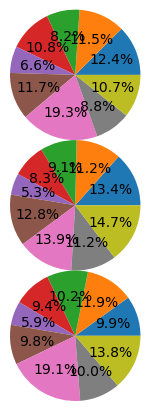

In [72]:
import matplotlib.pyplot as plt

# Make function to sort the tuples
def sortTup(e):
    return e[1]

# Initialize Plots
fig, axs = plt.subplots(3, 1, sharey=True)

# Go through each cluster
for result in results_clustered:
    # Sort features alphabetically to get colors to be the same
    result['features'].sort(key = sortTup)
      
    # Place the values in list and labels in a list
    val = [x[0] for x in result['features']]
    label = [x[1] for x in result['features']]
    
    axs[result['Class']].pie(val, autopct='%1.1f%%', radius =1.5)
    
    

In [104]:
list_for_df = []
for result in results_clustered:
    dict ={'Class': result['Class']}
    for feature in result['features']:
        dict[feature[1]] = feature[0]
    list_for_df.append(dict)
features_df = pd.DataFrame(list_for_df)
features_df = features_df.set_index('Class')
features_df

,Agility_3cone,BMI,Bench_Press_Reps,Broad_Jump,Height,Shuttle,Sprint_40yd,Vertical_Jump,Weight
Class,,,,,,,,,
2,0.099322,0.119272,0.101587,0.093788,0.059092,0.098406,0.190666,0.100335,0.137531
0,0.124498,0.114942,0.082015,0.107681,0.066089,0.116675,0.192866,0.088375,0.106860
1,0.134207,0.112345,0.090624,0.083088,0.053343,0.127881,0.138779,0.112326,0.147406


In [105]:
features_df = features_df.transpose()
features_df

Class,2,0,1
Agility_3cone,0.099322,0.124498,0.134207
BMI,0.119272,0.114942,0.112345
Bench_Press_Reps,0.101587,0.082015,0.090624
Broad_Jump,0.093788,0.107681,0.083088
Height,0.059092,0.066089,0.053343
Shuttle,0.098406,0.116675,0.127881
Sprint_40yd,0.190666,0.192866,0.138779
Vertical_Jump,0.100335,0.088375,0.112326
Weight,0.137531,0.106860,0.147406


In [106]:
features_df.to_csv('feature_importances.csv')